<a href="https://colab.research.google.com/github/Iampushyamithra/Automatic-Image-Captioning/blob/main/Imagecap_Flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Automatic Image Captioning using Flickr8k dataset

The method being implemented is the use of CNN for the feature representation and then generate captions using LSTM

### Install Necessary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Libraries:

In [ ]:
import string
import os
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import vgg16 
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, Add
from keras.preprocessing.text import Tokenizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

### Loading Data

In [ ]:
# Load data
images_dir = os.listdir("/content/drive/MyDrive/Project Work AI ML/Flicker8k_Dataset")

images_path ='/content/drive/MyDrive/Project Work AI ML/Flicker8k_Dataset'

folder= images_path


### Train and Test dataset split

In [ ]:
# define function to read text file
def load_text(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    text = text.split('\n')
    # close the file
    file.close()
    return text
filename = '/content/drive/MyDrive/Project Work AI ML/Flickr8k_text'

train_imgs = load_text(os.path.join(filename, "Flickr_8k.trainImages.txt"))

test_imgs = load_text(os.path.join(filename, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(filename, "Flickr_8k.devImages.txt"))

train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != ''] 



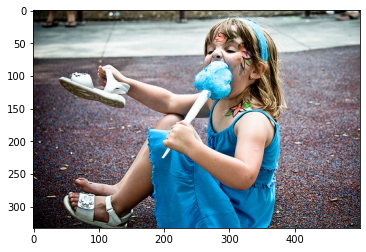

In [ ]:
image999 = train_imgs[999]
image_999 = load_img(os.path.join(images_path, image999))
plt.imshow(image_999) 


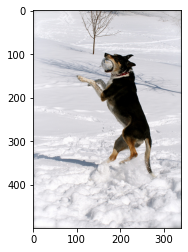

In [ ]:
image897 = train_imgs[897]
image_897 = load_img(os.path.join(images_path, image897))
plt.imshow(image_897)

### Importing the Inception V3 feature

  The end result would be of Dictionary format, with image name as key and Inception V3 features as value

In [ ]:
def get_inceptionv3_feature(img_folder, img_name, model):
    # Convert all the images to size 299x299 as expected by the
    # inception v3 model
    img = load_img(os.path.join(img_folder, img_name), target_size=(299,299))
    # Convert PIL image to numpy array of 3-dimensions
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x)
    x = model.predict(x)
    # reshape from (1, 2048) to (2048, )
    x = np.reshape(x, x.shape[1])
    return x
# Get the InceptionV3 model trained on imagenet data
model_inceptionv3 = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_inceptionv3 = Model(model_inceptionv3.input, model_inceptionv3.layers[-2].output)
incv3_features_img999 = get_inceptionv3_feature(folder, train_imgs[999], model_inceptionv3)
print("Shape of image vector for one image: {}".format(incv3_features_img999.shape))

Shape of image vector for one image: (2048,)


### Pre-Processing Text

Pre-processing includes:
 - tokenizing
 - converting the letters into lower-case
 - removal of punctuations
 - removal of single-letters such as 's' and a'

In [ ]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc:
        # split line by white space
        tokens = line.split()
        if len(tokens) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        # add 'startseq' and 'endseq' to each description
        image_desc = 'startseq '+' '.join(image_desc) + ' endseq'
        # store the first description for each image
        if image_id not in mapping.keys():
            mapping[image_id] = []
        mapping[image_id].append(image_desc)
    return mapping
def clean_description(desc_dict):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in desc_dict.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # store as string
            desc_list[i] =  ' '.join(desc)
descriptions = load_text(os.path.join(filename, "Flickr8k.token.txt"))
desc_dict = load_descriptions(descriptions)
clean_description(desc_dict)

### Extracting GloVe embeddings

These are pre-trained word embeddings of 200 dimensions 


In [ ]:
# Create the vocabulary.
vocabulary = set()
for key in desc_dict.keys():
    [vocabulary.update(d.split()) for d in desc_dict[key]]
vocabulary = list(vocabulary)
print('Original Vocabulary Size: %d' % len(vocabulary))
# Create the word <--> index mappers.
# NOTE: index starts from 1, not 0.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
# Load Glove vectors
glove_folder = '/content/drive/MyDrive/Project Work AI ML/archive'

embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_folder, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print("Volcabulary size of GLOVE: {}".format(len(embeddings_index)))
# Get 200-dim dense vector for each of words in vocabulary
embedding_dim = 200
vocab_size = len(vocabulary)+1    # added 1 for padding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
print("Shape of embedding weights for the current vocabulary {}".format(embedding_matrix.shape))



Original Vocabulary Size: 8810
Volcabulary size of GLOVE: 400000
Shape of embedding weights for the current vocabulary (8811, 200)


In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)
# define the data generator function
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0
max_length= max_length(desc_dict)

encoded_train_images = images_path 



print('Max Description Length: %d ' % max_length)

num_photos_per_batch =5
batch_generator = data_generator(descriptions=desc_dict,
               photos=encoded_train_images, wordtoix=wordtoix, max_length=max_length, 
               num_photos_per_batch=num_photos_per_batch)
inputs, outputs = next(batch_generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

Max Description Length: 34 


TypeError: ignored

TypeError: ignored

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# use pre-fixed weights for embeddding layer and not trainable.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
for ep in range(1, num_epoch):
    print("run epoch {}".format(ep))
    model.fit_generator(generator=train_generator, steps_per_epoch=len(encoded_train_images), epochs=1)
    model.save(os.path.join(proc_folder, 'inceptionv3_trained', "trained_model_{}epochs.h5".format(ep)))

NameError: ignored

In [ ]:
def caption_generator_incpt3glove(photo, model, max_length, wordtoix, ixtoword):
    # start with 'stratseq'
    in_text = ['startseq']
    # iterate over the maximal length of description
    for s in range(max_length):
        seq = [wordtoix[i] for i in in_text]
        seq = pad_sequences([seq], maxlen=max_length)[0]
in_put = [np.array([photo]), np.array([seq])]
       
out_word = model.predict(in_put, verbose=0)
        # convert probability to integer
out_word = np.argmax(out_word)
        # map ix to word
out_word = ixtoword[out_word]
        # stop if we cannot map the word
if out_word is None:
  break
        # append as input for generating the next word
in_text.append(out_word)
        # stop if we predict the end of the sequence
if out_word == 'endseq':
  break
return in_text

NameError: ignored